# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Alpha](#Alpha)
* [Discussion](#Discussion)

# Introduction

This is a post hoc tuning after seeing disappointing holdout results. We dropped ridge earlier for simplicity and speed, but now it's back in.

Since I'm close to wrapping up at this point, we'll do a quick tune and won't stop to evaluate too much.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

import swifter

# typing
from typing import Dict, List, Sequence

# other sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold

# params
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.92 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 114 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather(
        f"{FEATURES_FOLDER}/scaled_features_ready_for_selection.feather"
    ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
_ = gc_collect()

time: 228 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 51 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   LDA1                                                                           85740 non-null  float64
 1   LDA2                                                                           85740 non-null  float64
 2   ocLDA_neg                                                                      85740 non-null  float64
 3   ocLDA_neu                                                                      85740 non-null  float64
 4   ocLDA_pos                                                                      85740 non-null  float64
 5   ocSVM_sgdlinear_LDA1                                                           85740 non-null  float64
 6   ocSVM_sgdlinear_LDA2 

# Strata

In [7]:
N_SPLITS = 8

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 85740/85740 [00:00<00:00, 92537.32it/s]


time: 1.03 s


In [8]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 116 ms


In [9]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
STRATA.value_counts()
cross_validator = lambda: StratifiedGroupKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=SEED
).split(X=data, y=STRATA, groups=labels.speaker_id)

merge passes performed: 0
only 1: 52
only 2: 37
only 3: 31
only 4: 17
only 5: 27
only 6: 13
only 7: 9
merge passes performed: 1
only 1: 43
only 2: 24
only 3: 4
only 4: 1
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 2
only 1: 42
only 2: 20
only 3: 0
only 4: 0
only 5: 5
only 6: 0
only 7: 0
merge passes performed: 3
only 1: 37
only 2: 0
only 3: 0
only 4: 10
only 5: 0
only 6: 5
only 7: 0
merge passes performed: 4
only 1: 32
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 5
merge passes performed: 5
only 1: 27
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 6
only 1: 1
only 2: 1
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 7
only 1: 0
only 2: 0
only 3: 1
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 8
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0


MELDmneu1engmedium               2905
MELDfneu1engmedium               2452
esdfneu1engmedium                1750
esdfhap2engmedium                1750
esdfsur0engmedium                1750
esdmneu1cmnmedium                1750
esdmhap2cmnmedium                1750
esdmang0cmnmedium                1750
esdfneu1cmnmedium                1749
esdfhap2cmnmedium                1749
esdmsur0cmnmedium                1749
esdmsur0engmedium                1749
esdfang0engmedium                1748
esdfang0cmnmedium                1747
esdmneu1engmedium                1747
esdmang0engmedium                1746
esdfsad0engmedium                1744
esdmhap2engmedium                1744
esdfsur0cmnmedium                1737
esdmsad0engmedium                1735
esdmsad0cmnmedium                1713
LEGOv2fneu1engmedium             1673
esdfsad0cmnmedium                1474
LEGOv2mneu1engmedium             1309
MELDfhap2engmedium                931
MELDmhap2engmedium                908
EmoV-DB_sort

time: 1.83 s


# Hyperparameters

In [10]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={
        "base_estimator__alpha": loguniform(1e-3, 1e3),
        "base_estimator__class_weight": ["balanced", None],
    },
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 1,
    error_score="raise",
).fit(data, labels.valence)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
time: 22.3 s


-0.7288252199340497
{'base_estimator__alpha': 2.4393756512674267, 'base_estimator__class_weight': None}


<AxesSubplot:xlabel='param_base_estimator__alpha'>

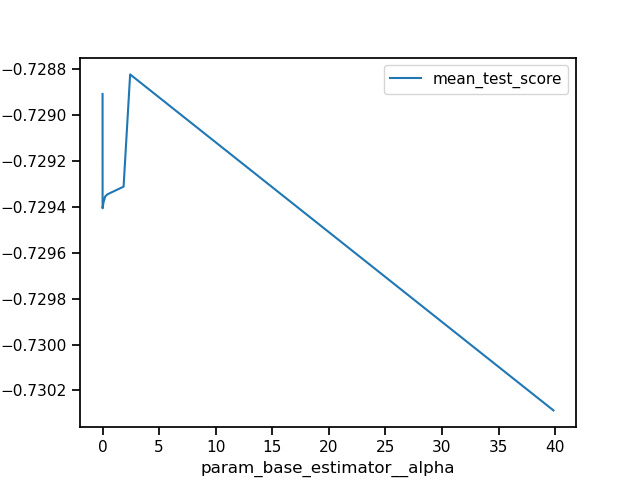

time: 203 ms


In [11]:
print(model.best_score_)
print(model.best_params_)
results_df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

In [12]:
df = pd.DataFrame(model.cv_results_)
df.param_base_estimator__class_weight = df.param_base_estimator__class_weight.astype(
    str
)
df.groupby("param_base_estimator__class_weight").mean()

mean_fit_time  std_fit_time  \
param_base_estimator__class_weight                                
None                                     1.418210      0.115801   
balanced                                 1.458937      0.165325   

                                    mean_score_time  std_score_time  \
param_base_estimator__class_weight                                    
None                                       0.115091        0.040695   
balanced                                   0.122578        0.041768   

                                    split0_test_score  split1_test_score  \
param_base_estimator__class_weight                                         
None                                        -0.648088          -0.841994   
balanced                                    -0.651075          -0.846857   

                                    split2_test_score  split3_test_score  \
param_base_estimator__class_weight                                         
None                                        -0.891230          -0.748187   
balanced                                    -0.888616          -0.748146   

                                    split4_test_score  split5_test_score  \
param_base_estimator__class_weight                                         
None                                        -0.823341          -0.631003   
balanced                                    -0.830581          -0.627061   

                                    split6_test_score  split7_test_score  \
param_base_estimator__class_weight                                         
None                                        -0.613059          -0.634155   
balanced                                    -0.612714          -0.630950   

                                    mean_test_score  std_test_score  \
param_base_estimator__class_weight                                    
None                                      -0.728882        0.104249   
balanced                                  -0.729500        0.105861   

                                    rank_test_score  
param_base_estimator__class_weight                   
None                                            2.0  
balanced                                        7.0

time: 23 ms


In [13]:
def tune(alpha: Sequence, results_df: pd.DataFrame, n_iter: int = 10) -> pd.DataFrame:
    """Run tuning procedure"""
    model = RandomizedSearchCV(
        estimator=CalibratedClassifierCV(
            base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
            method="isotonic",
            n_jobs=-1,
        ),
        param_distributions={"base_estimator__alpha": alpha},
        n_iter=n_iter,
        scoring="neg_log_loss",
        n_jobs=-1,
        cv=list(cross_validator()),
        verbose=1,
        random_state=SEED + 2,
        error_score="raise",
    ).fit(data, labels.valence)

    print("best score:", model.best_score_)
    print("best params:", model.best_params_)
    df = (
        pd.DataFrame(model.cv_results_)
        .sort_values(by="param_base_estimator__alpha", ascending=True)
        .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
    )
    df.plot(x="param_base_estimator__alpha", y="mean_test_score")
    plt.show()
    return pd.concat(
        [results_df.loc[:, ["param_base_estimator__alpha", "mean_test_score"]], df],
        axis="rows",
    )


_ = gc_collect()

time: 116 ms


Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288179205760761
best params: {'base_estimator__alpha': 3.373549705407809}


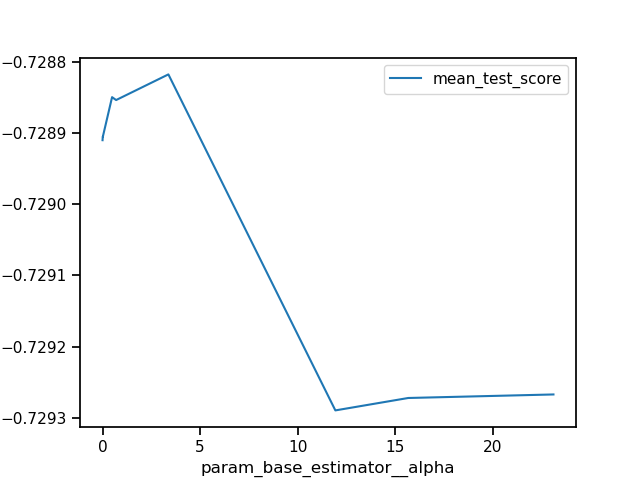

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7284545318961155
best params: {'base_estimator__alpha': 679.4015235251416}


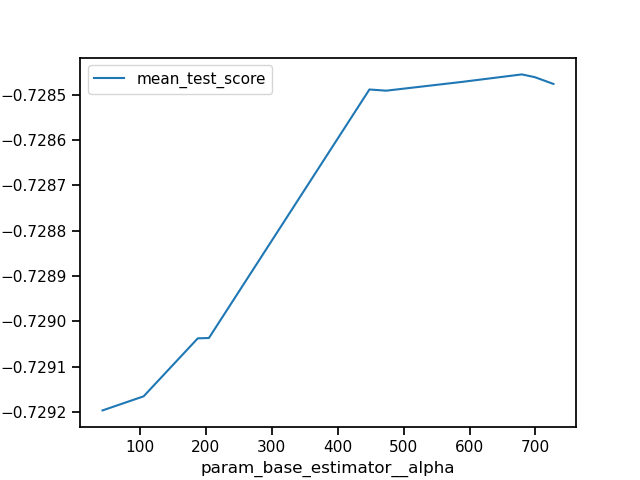

time: 38.4 s


In [14]:
df = tune(alpha=loguniform(1e-3, 1e3), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-3, 1e3), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288325579820168
best params: {'base_estimator__alpha': 2.249355378452717}


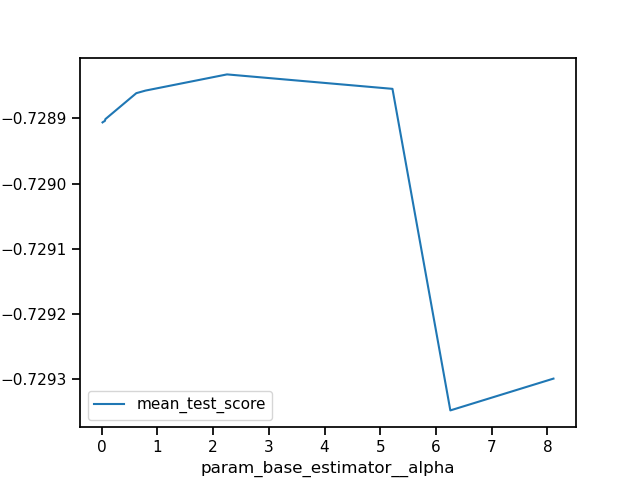

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288106310309272
best params: {'base_estimator__alpha': 4.390856374686481}


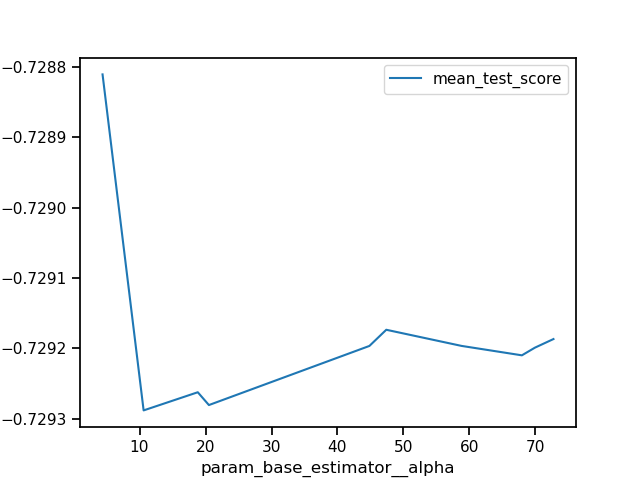

time: 38.2 s


In [15]:
df = tune(alpha=loguniform(1e-2, 1e2), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 1e2), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.728839131017879
best params: {'base_estimator__alpha': 1.0919470279424939}


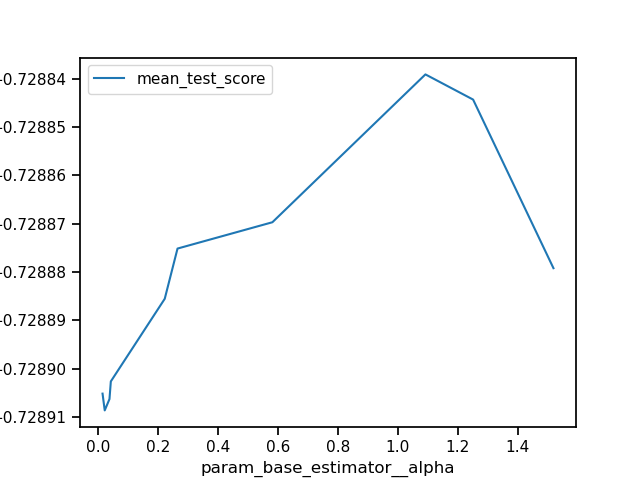

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288166693099658
best params: {'base_estimator__alpha': 4.492958244803045}


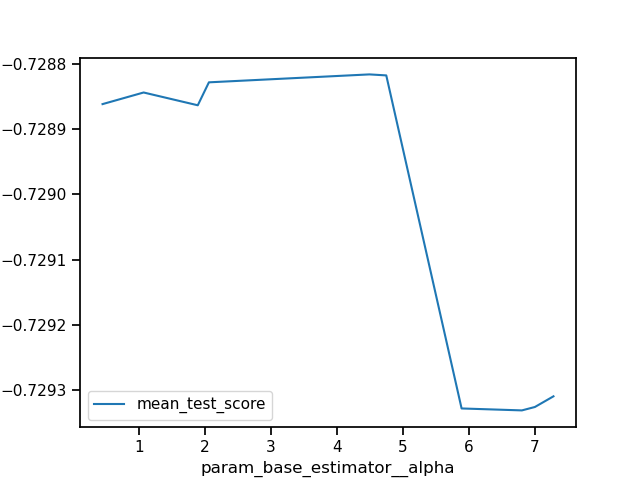

time: 37.9 s


In [16]:
df = tune(alpha=loguniform(1e-2, 10), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 10), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288460253847764
best params: {'base_estimator__alpha': 0.5001597596973489}


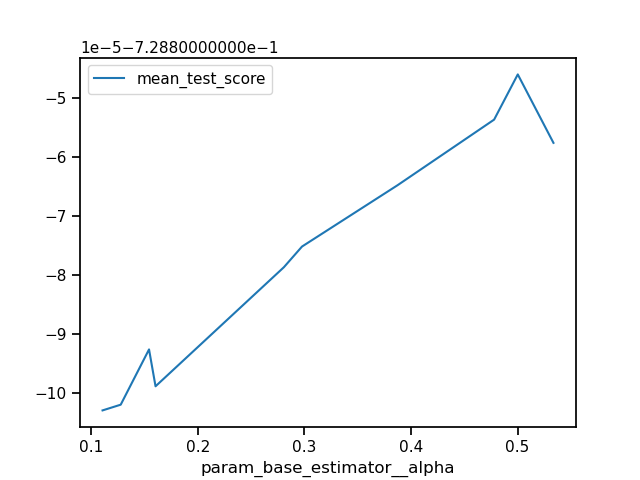

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288450301367784
best params: {'base_estimator__alpha': 0.5034662420322742}


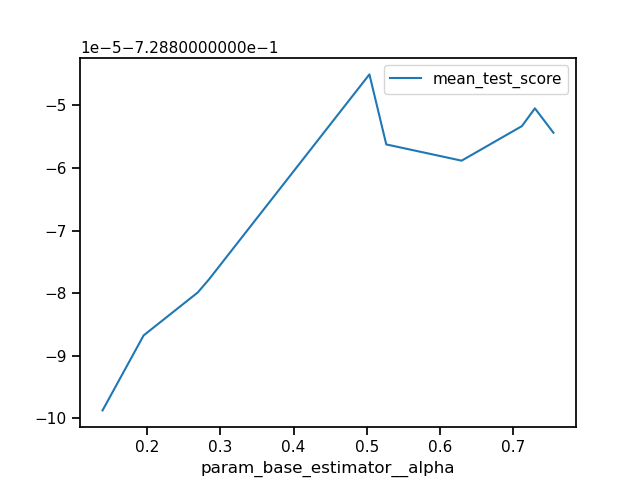

time: 38.1 s


In [17]:
df = tune(alpha=loguniform(0.1, 1), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.1, 0.9), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288302650336165
best params: {'base_estimator__alpha': 1.1116081805372156}


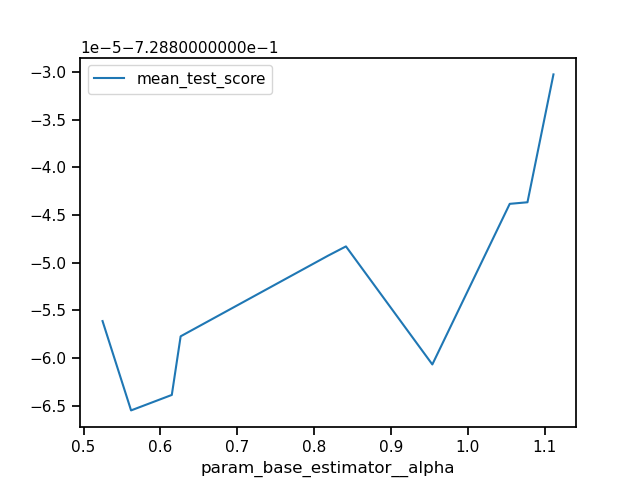

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288318828039473
best params: {'base_estimator__alpha': 1.1794005235251417}


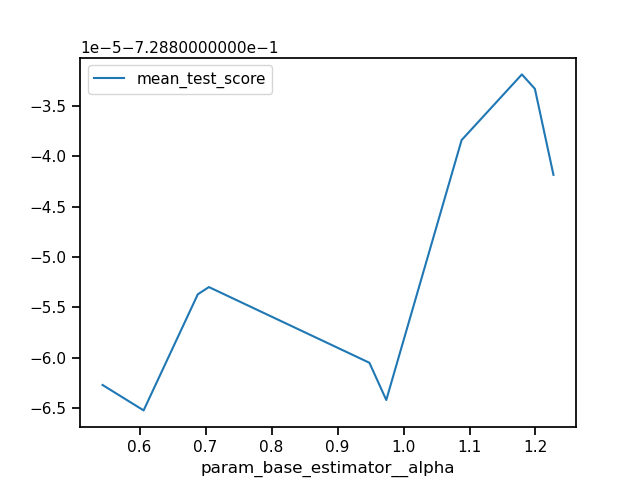

time: 37.7 s


In [18]:
df = tune(alpha=loguniform(0.5, 1.5), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.5, 1.0), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288442123754165
best params: {'base_estimator__alpha': 0.8343029820518453}


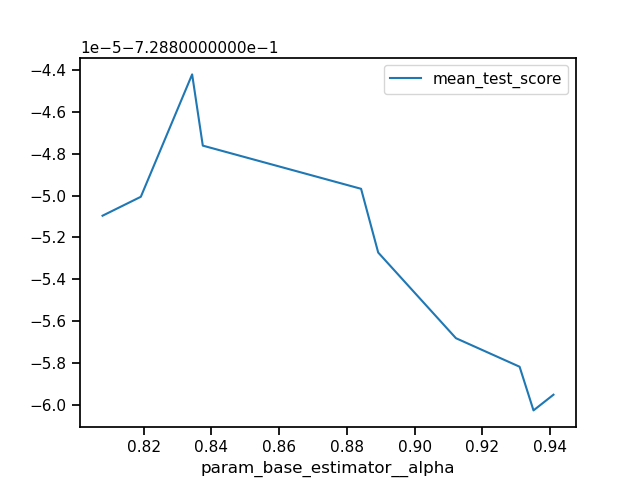

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288478551341269
best params: {'base_estimator__alpha': 0.8376303920077013}


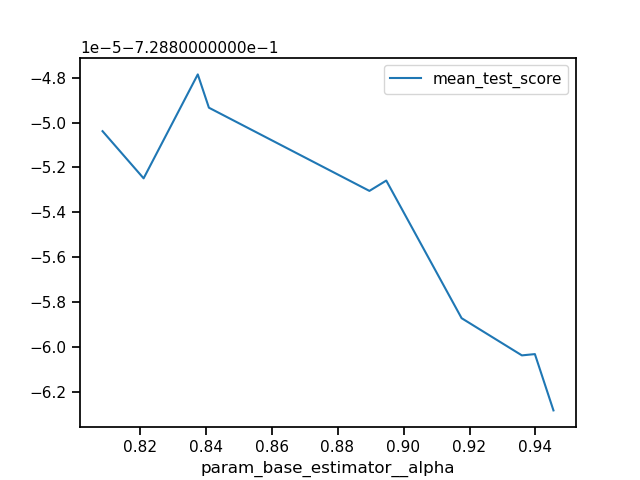

time: 38.8 s


In [19]:
df = tune(alpha=loguniform(0.8, 1.0), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.8, 0.2), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288468591619122
best params: {'base_estimator__alpha': 1.0414096933928414}


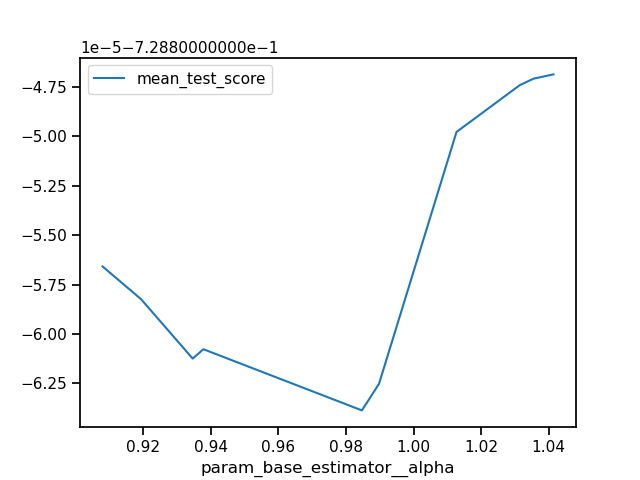

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7288453290624411
best params: {'base_estimator__alpha': 1.045448028736891}


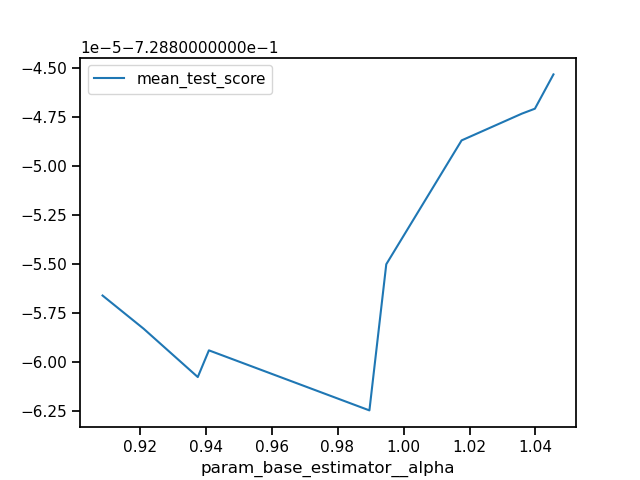

time: 38.2 s


In [20]:
df = tune(alpha=loguniform(0.9, 1.1), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.9, 0.2), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7283099930645769
best params: {'base_estimator__alpha': 2309.0900086512424}


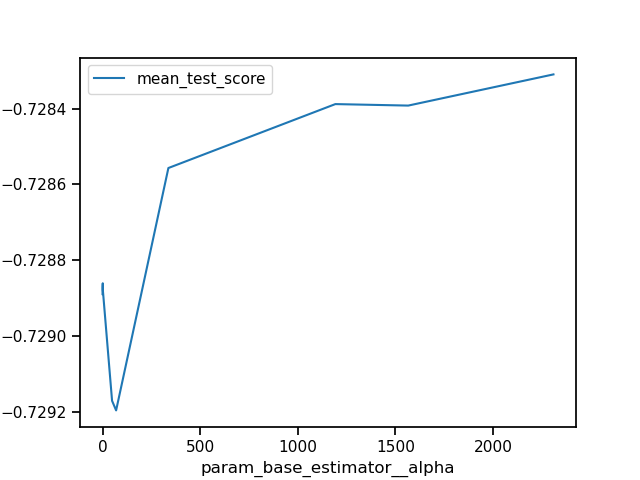

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7271505303414115
best params: {'base_estimator__alpha': 44829.68244803046}


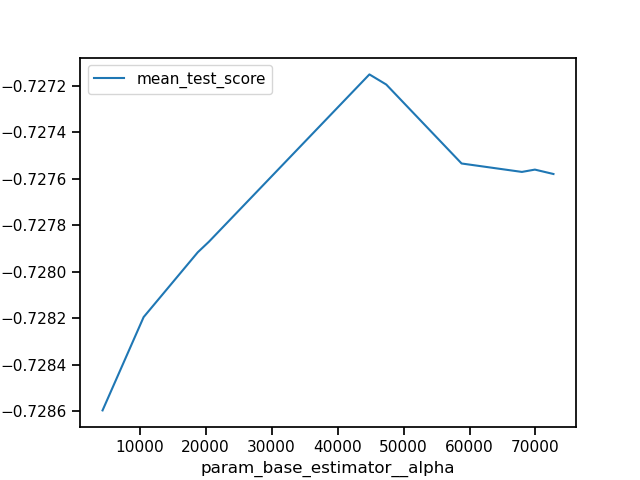

time: 38.2 s


In [21]:
df = tune(alpha=loguniform(0.1, 1e5), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.1, 1e5), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7279719242482613
best params: {'base_estimator__alpha': 108308.46985724186}


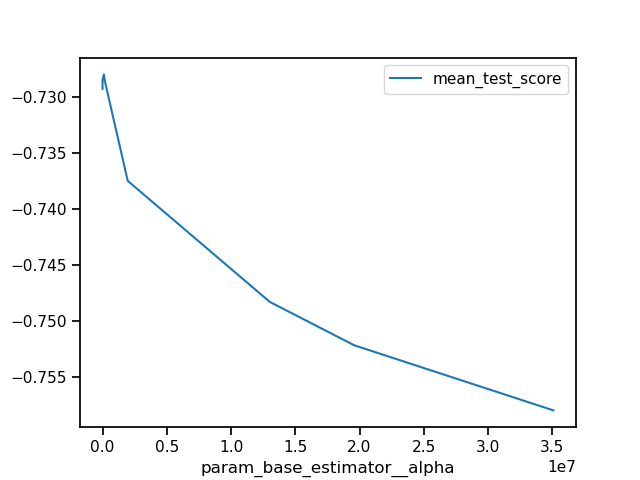

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7786462799965381
best params: {'base_estimator__alpha': 438085647.46864814}


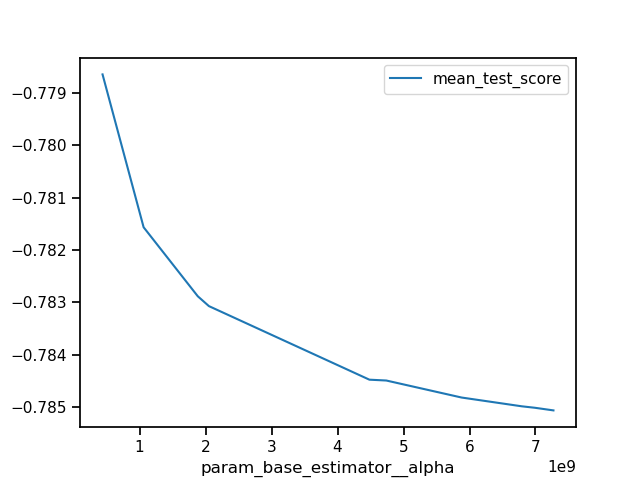

time: 38.2 s


In [22]:
df = tune(alpha=loguniform(10, 1e10), results_df=df, n_iter=10)
df = tune(alpha=uniform(10, 1e10), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7277400922779012
best params: {'base_estimator__alpha': 23400.68211707545}


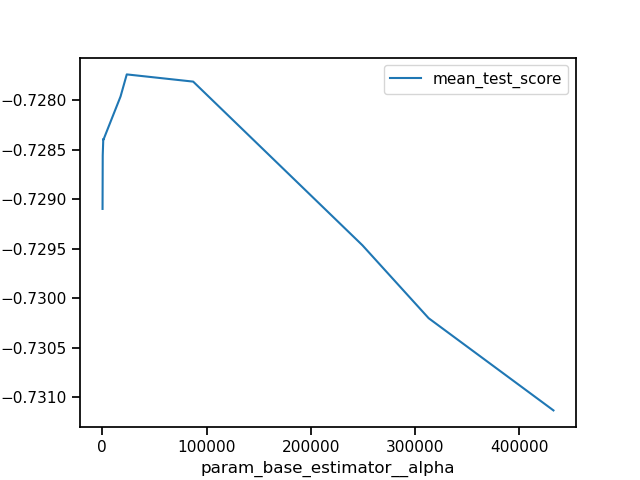

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7311802080422634
best params: {'base_estimator__alpha': 438185.63746864814}


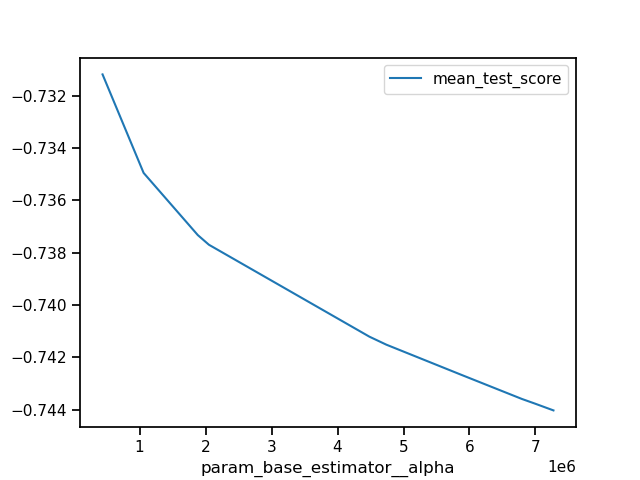

time: 38 s


In [23]:
df = tune(alpha=loguniform(100, 1e7), results_df=df, n_iter=10)
df = tune(alpha=uniform(100, 1e7), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7271976121401944
best params: {'base_estimator__alpha': 26395.938645735514}


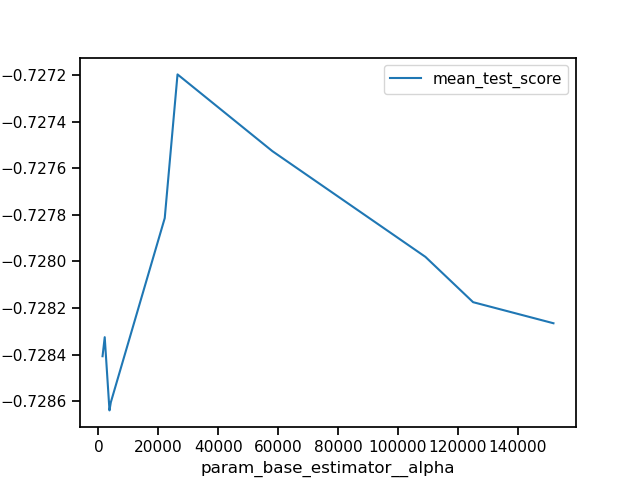

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7271497310662983
best params: {'base_estimator__alpha': 44808.56374686481}


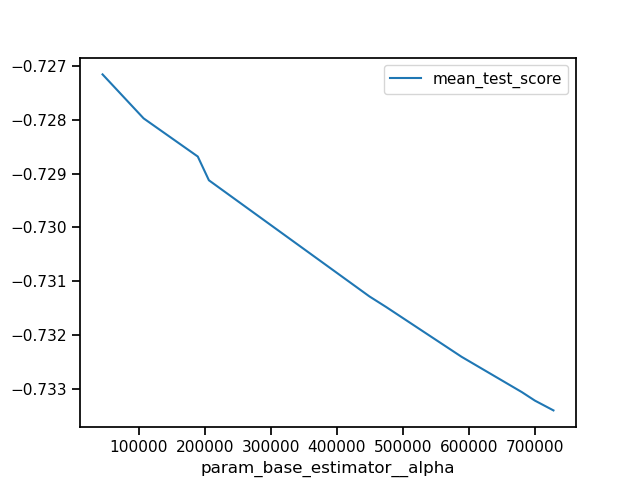

time: 37.8 s


In [24]:
df = tune(alpha=loguniform(1000, 1e6), results_df=df, n_iter=10)
df = tune(alpha=uniform(1000, 1e6), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.727995575574637
best params: {'base_estimator__alpha': 110613.60936306213}


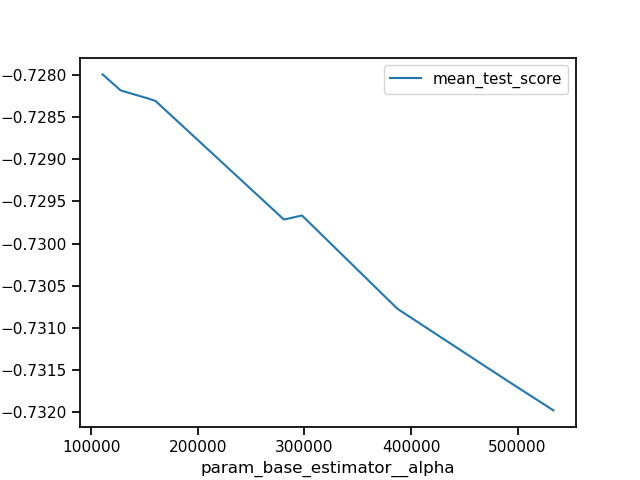

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7283561075124789
best params: {'base_estimator__alpha': 143808.56374686482}


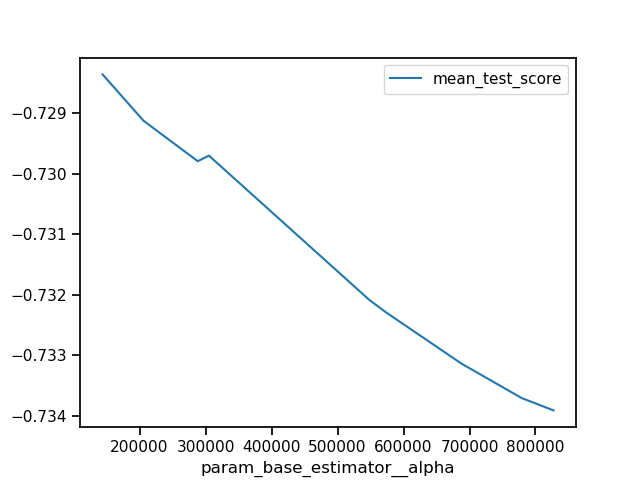

time: 38.3 s


In [25]:
df = tune(alpha=loguniform(1e5, 1e6), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e5, 1e6), results_df=df, n_iter=10)

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7274761115158381
best params: {'base_estimator__alpha': 51561.45781020939}


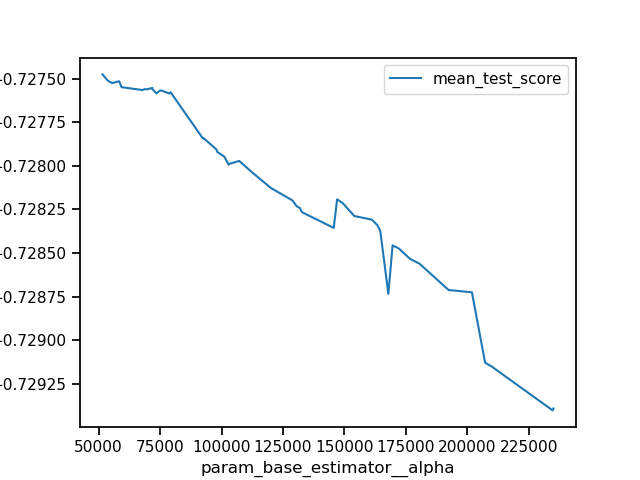

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7275015049072528
best params: {'base_estimator__alpha': 53821.38957449321}


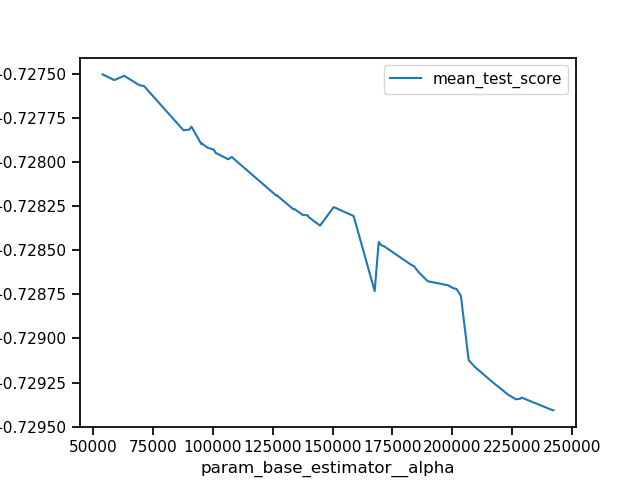

time: 2min 49s


In [26]:
df = tune(alpha=loguniform(50000, 250000), results_df=df, n_iter=50)
df = tune(alpha=uniform(50000, 200000), results_df=df, n_iter=50)

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7275535611335276
best params: {'base_estimator__alpha': 76697.31110354883}


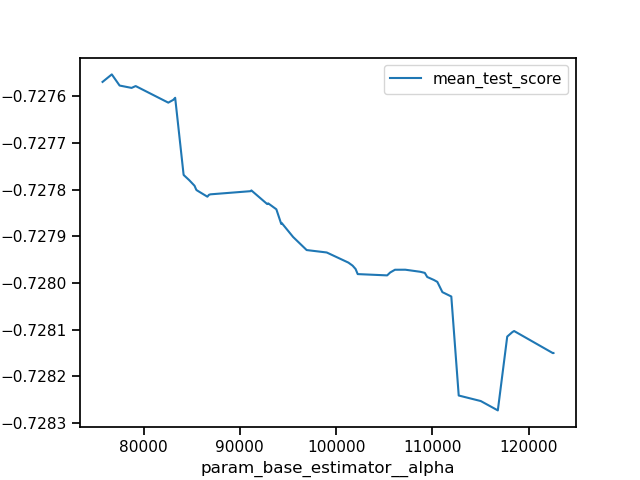

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7275704801847589
best params: {'base_estimator__alpha': 78218.18454406357}


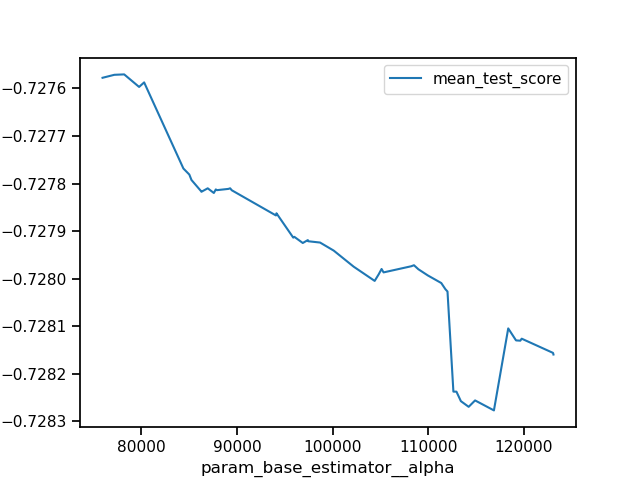

time: 2min 48s


In [27]:
df = tune(alpha=loguniform(75000, 125000), results_df=df, n_iter=50)
df = tune(alpha=uniform(75000, 50000), results_df=df, n_iter=50)

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7288059707438352
best params: {'base_estimator__alpha': 2.8476085442586023}


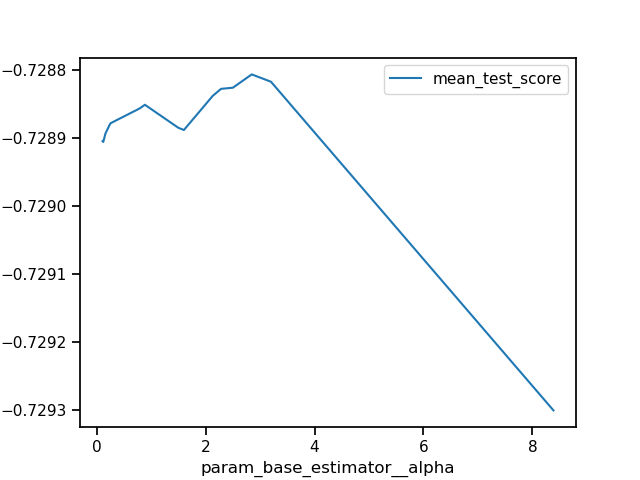

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.728817836706322
best params: {'base_estimator__alpha': 4.538128662355015}


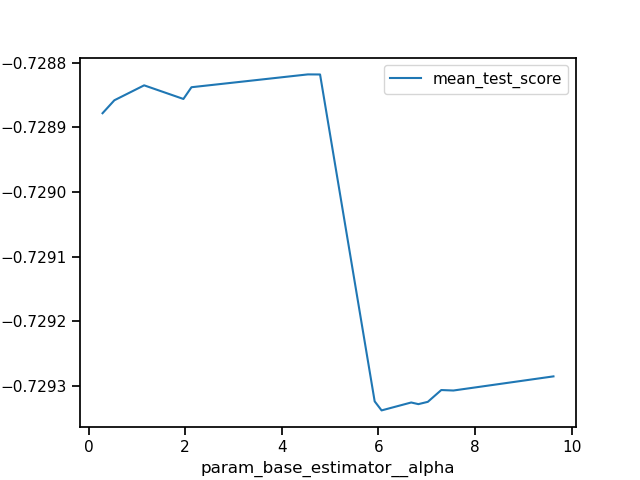

time: 54.7 s


In [28]:
df = tune(alpha=loguniform(0.1, 10), results_df=df, n_iter=15)
df = tune(alpha=uniform(0.1, 9.9), results_df=df, n_iter=15)

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7269385864676361
best params: {'base_estimator__alpha': 39858.31953692612}


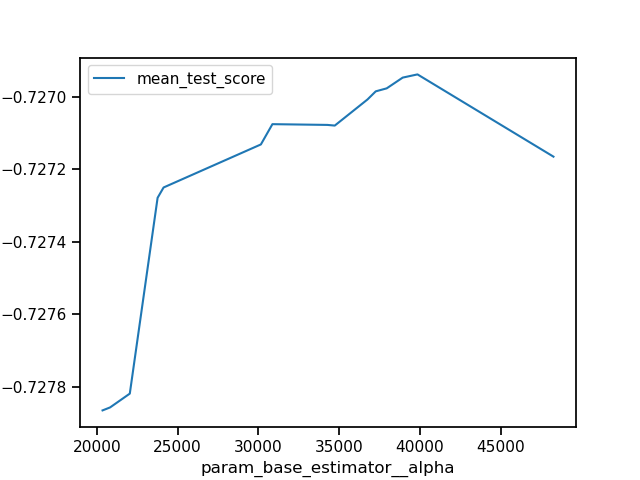

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7269417851904127
best params: {'base_estimator__alpha': 39931.05942069427}


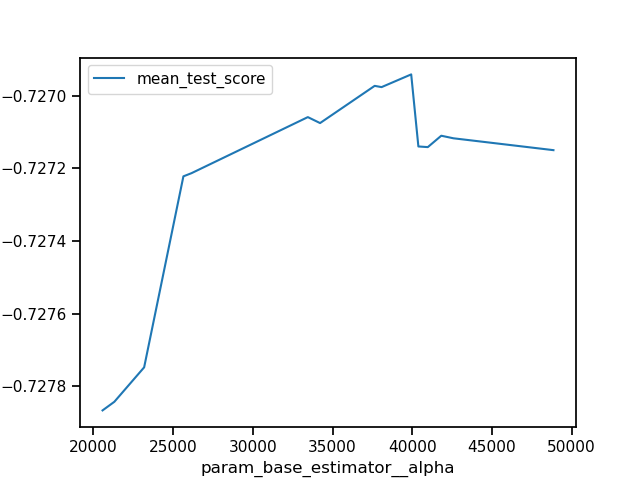

time: 54.9 s


In [29]:
df = tune(alpha=loguniform(20000, 50000), results_df=df, n_iter=15)
df = tune(alpha=uniform(20000, 30000), results_df=df, n_iter=15)

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7269515434032856
best params: {'base_estimator__alpha': 39096.33288066238}


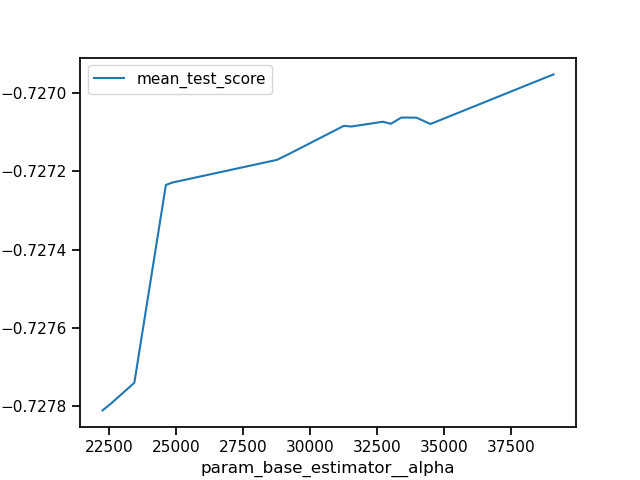

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7271393496089198
best params: {'base_estimator__alpha': 29694.220602465517}


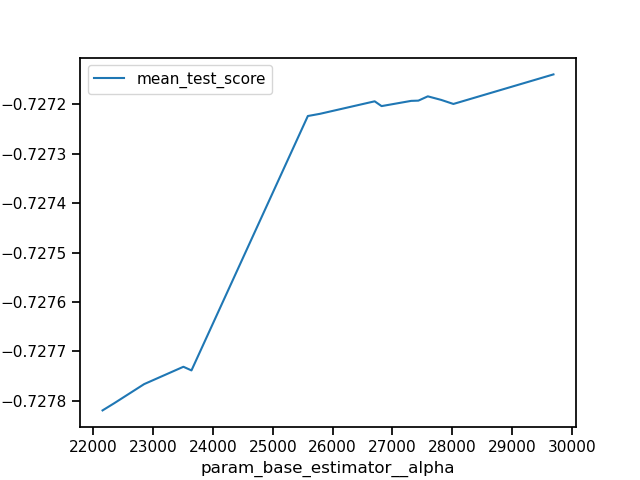

time: 54.4 s


In [30]:
df = tune(alpha=loguniform(22000, 40000), results_df=df, n_iter=15)
df = tune(alpha=uniform(22000, 8000), results_df=df, n_iter=15)

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7270595202848653
best params: {'base_estimator__alpha': 32007.0373360285}


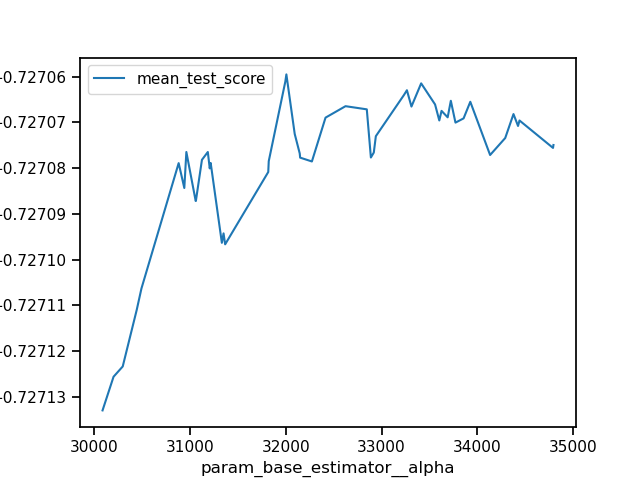

Fitting 8 folds for each of 50 candidates, totalling 400 fits
best score: -0.7270590135024175
best params: {'base_estimator__alpha': 33397.00261762571}


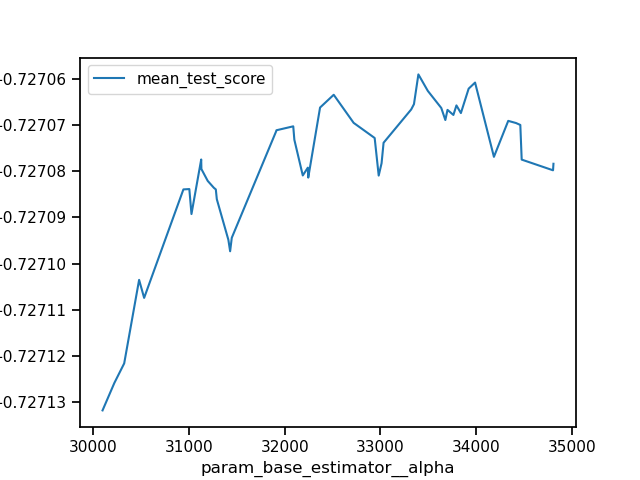

time: 2min 48s


In [31]:
df = tune(alpha=loguniform(30000, 35000), results_df=df, n_iter=50)
df = tune(alpha=uniform(30000, 5000), results_df=df, n_iter=50)

Fitting 8 folds for each of 13 candidates, totalling 104 fits
best score: -0.7270701557366721
best params: {'base_estimator__alpha': 31930.828142357925}


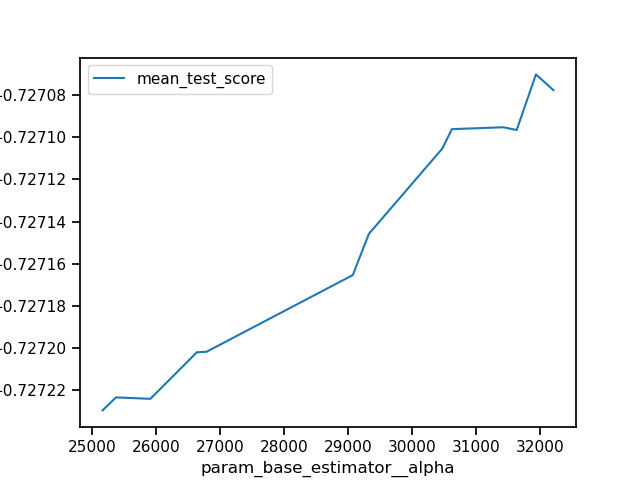

Fitting 8 folds for each of 13 candidates, totalling 104 fits
best score: -0.7270600355079192
best params: {'base_estimator__alpha': 32525.983372085793}


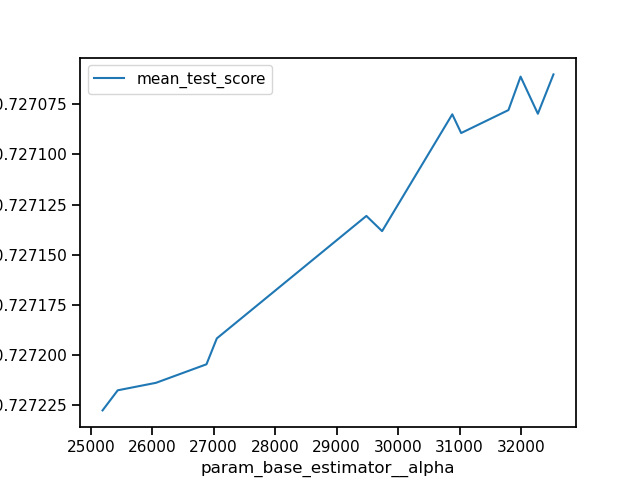

time: 47.9 s


In [32]:
df = tune(alpha=loguniform(25000, 35000), results_df=df, n_iter=13)
df = tune(alpha=uniform(25000, 10000), results_df=df, n_iter=13)

Fitting 8 folds for each of 13 candidates, totalling 104 fits
best score: -0.7270589964831276
best params: {'base_estimator__alpha': 33400.50364763719}


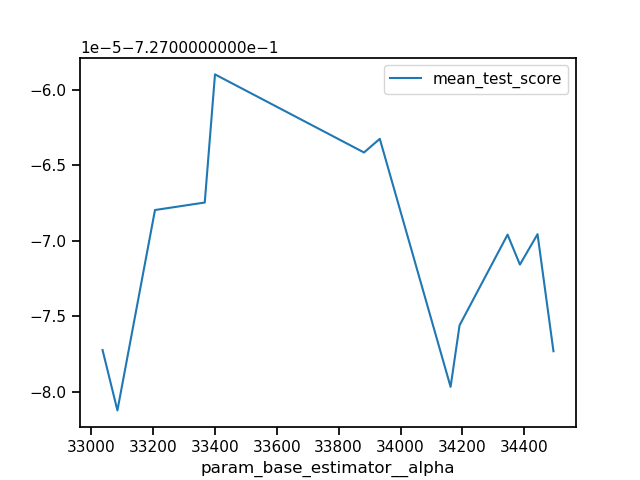

Fitting 8 folds for each of 13 candidates, totalling 104 fits
best score: -0.7270598347311893
best params: {'base_estimator__alpha': 33410.03790478858}


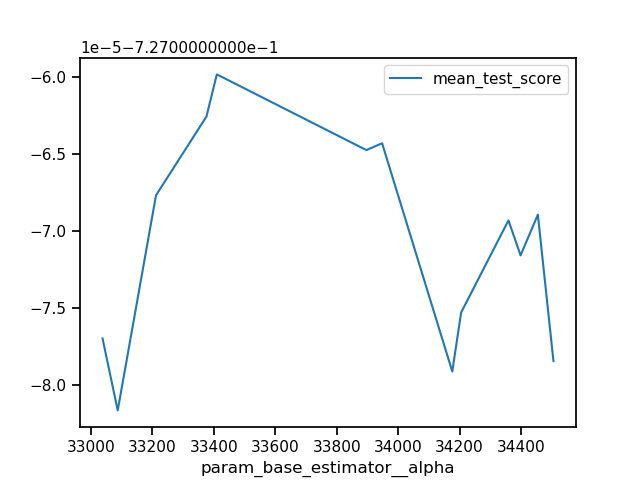

time: 48 s


In [33]:
df = tune(alpha=loguniform(33000, 35000), results_df=df, n_iter=13)
df = tune(alpha=uniform(33000, 2000), results_df=df, n_iter=13)

Fitting 8 folds for each of 13 candidates, totalling 104 fits
best score: -0.7270599328128148
best params: {'base_estimator__alpha': 32006.88921887737}


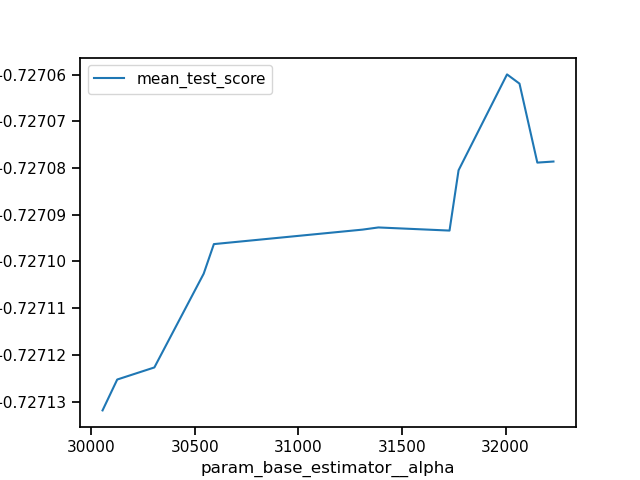

Fitting 8 folds for each of 13 candidates, totalling 104 fits
best score: -0.7270548952029435
best params: {'base_estimator__alpha': 32038.201570575424}


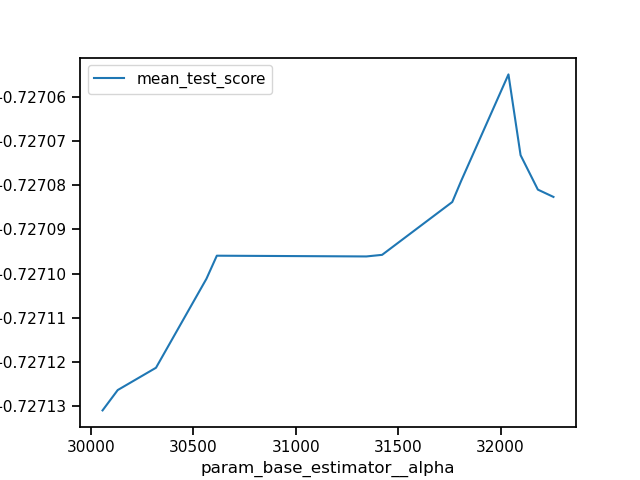

time: 47.8 s


In [34]:
df = tune(alpha=loguniform(30000, 33000), results_df=df, n_iter=13)
df = tune(alpha=uniform(30000, 3000), results_df=df, n_iter=13)

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7270606851916446
best params: {'base_estimator__alpha': 33989.51369304857}


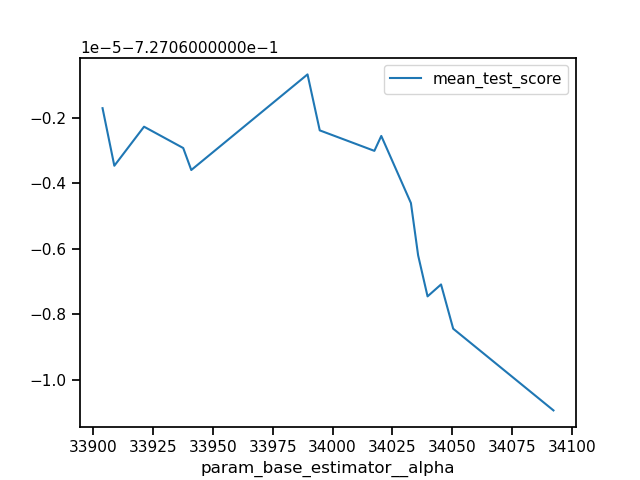

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7270609403794595
best params: {'base_estimator__alpha': 33989.65916489606}


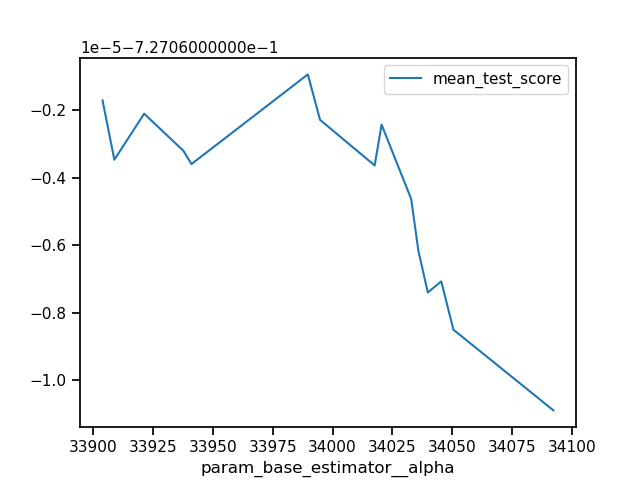

time: 54.5 s


In [35]:
plt.close("all")
df = tune(alpha=loguniform(33900, 34100), results_df=df, n_iter=15)
df = tune(alpha=uniform(33900, 200), results_df=df, n_iter=15)

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7270678791343457
best params: {'base_estimator__alpha': 34051.907948002}


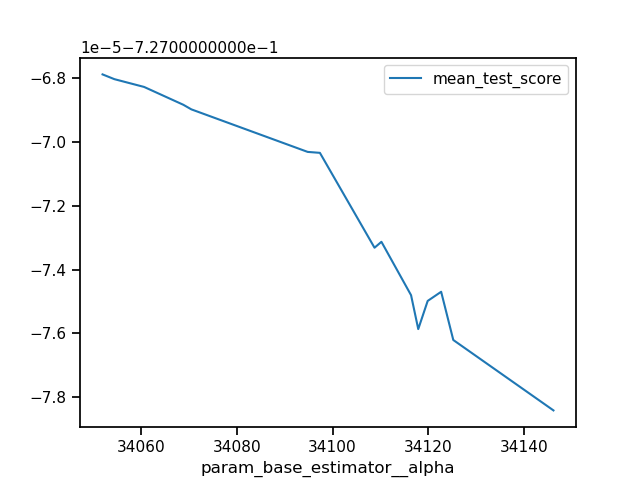

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7270678787887661
best params: {'base_estimator__alpha': 34051.91069478725}


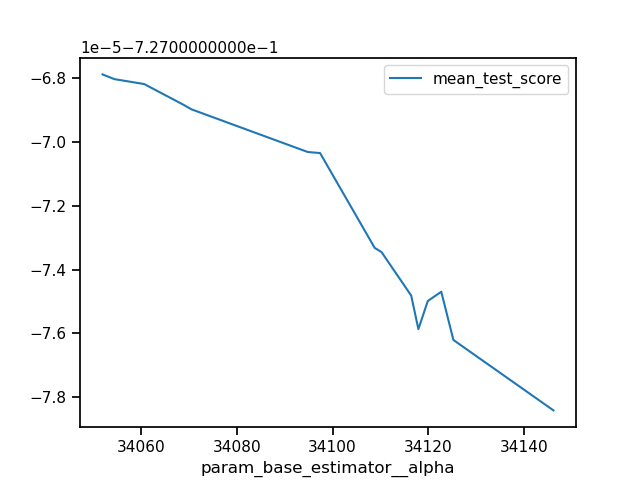

time: 55.2 s


In [36]:
df = tune(alpha=loguniform(34050, 34150), results_df=df, n_iter=15)
df = tune(alpha=uniform(34050, 100), results_df=df, n_iter=15)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7270744604814143
best params: {'base_estimator__alpha': 34122.12070192992}


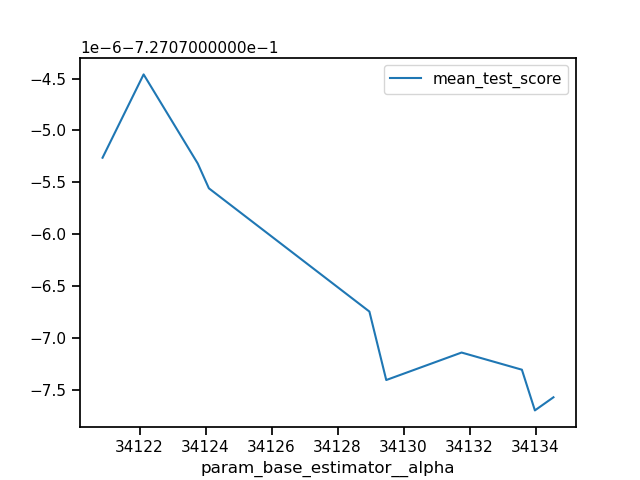

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7270744605456325
best params: {'base_estimator__alpha': 34122.121257489525}


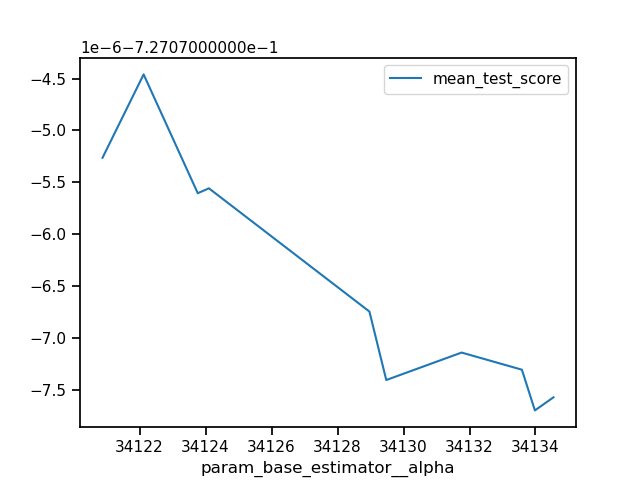

time: 38.4 s


In [37]:
df = tune(alpha=loguniform(34120, 34140), results_df=df, n_iter=10)
df = tune(alpha=uniform(34120, 20), results_df=df, n_iter=10)

Fitting 8 folds for each of 100 candidates, totalling 800 fits
best score: -0.7271130469469268
best params: {'base_estimator__alpha': 41473.98374128035}


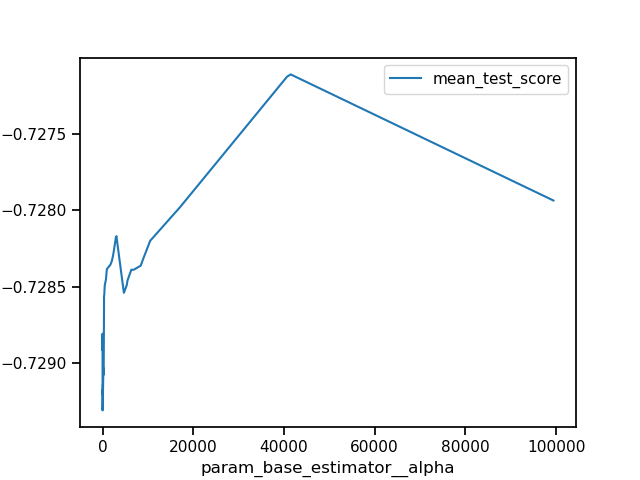

Fitting 8 folds for each of 100 candidates, totalling 800 fits
best score: -0.7271258017602438
best params: {'base_estimator__alpha': 43808.56374786481}


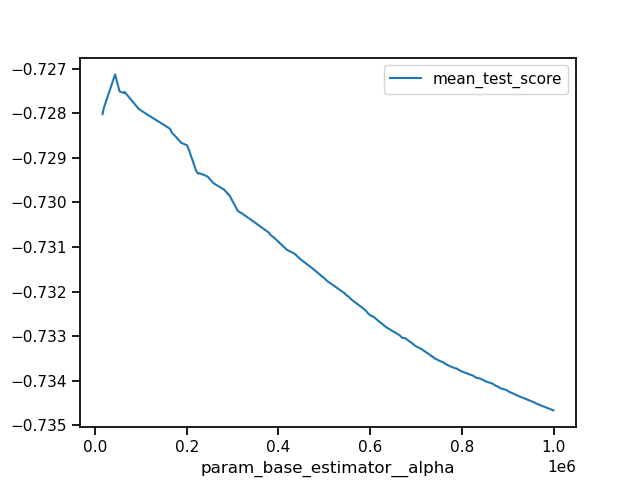

time: 5min 33s


In [38]:
df = tune(alpha=loguniform(1e-5, 1e5), results_df=df, n_iter=100)
df = tune(alpha=uniform(1e-6, 1e6), results_df=df, n_iter=100)
plt.close("all")

Fitting 8 folds for each of 100 candidates, totalling 800 fits
best score: -0.7269321350604947
best params: {'base_estimator__alpha': 39803.81200268135}


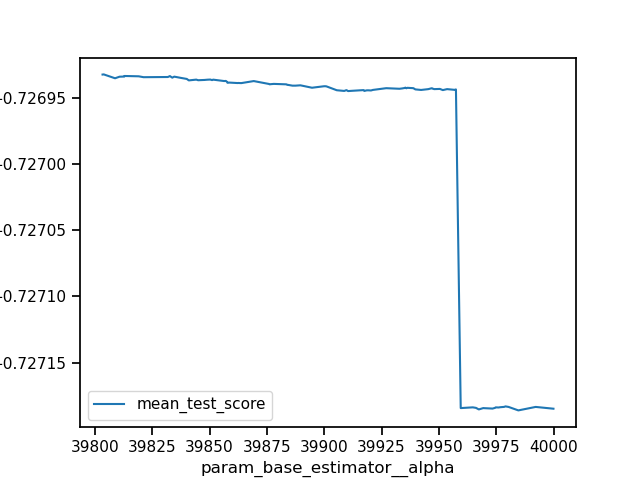

Fitting 8 folds for each of 100 candidates, totalling 800 fits
best score: -0.7269321345934486
best params: {'base_estimator__alpha': 39803.82138957449}


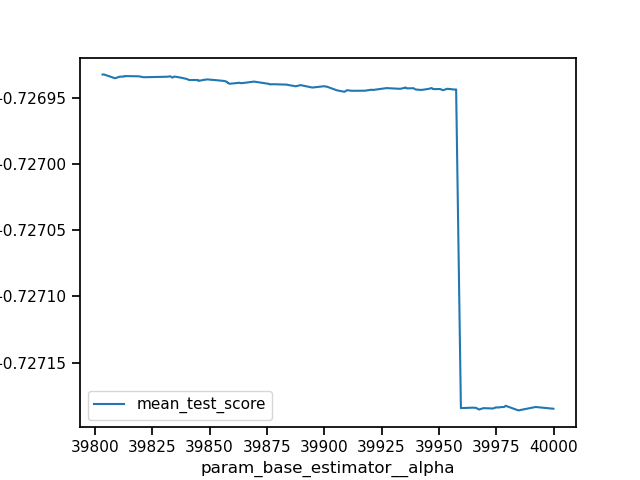

time: 5min 59s


In [43]:
df = tune(alpha=loguniform(39800, 40000), results_df=df, n_iter=100)
df = tune(alpha=uniform(39800, 200), results_df=df, n_iter=100)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7269295102392663
best params: {'base_estimator__alpha': 39760.59438012295}


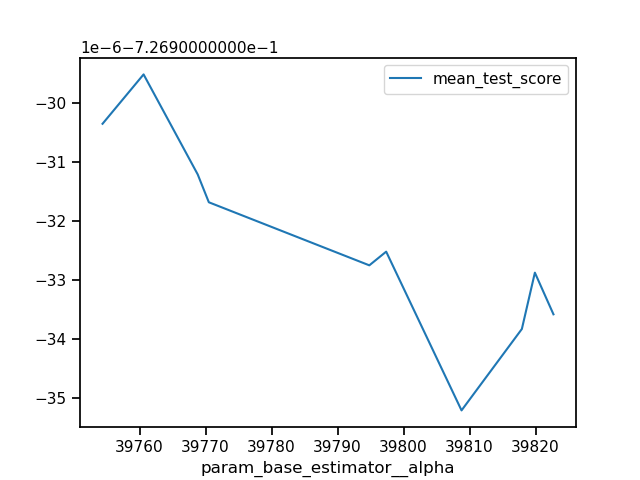

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7269295870805458
best params: {'base_estimator__alpha': 39760.60628744763}


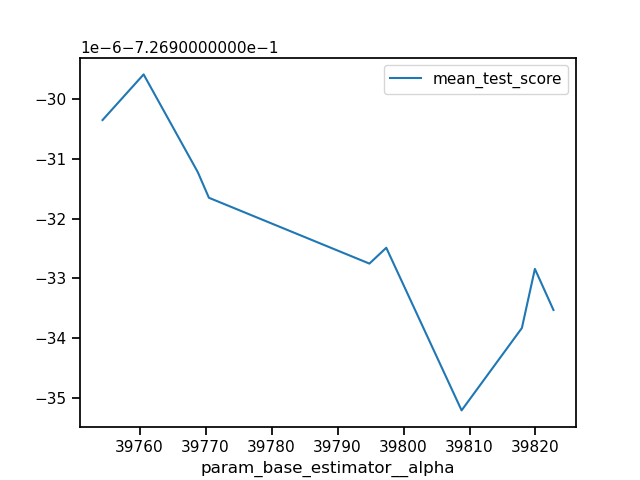

time: 41.9 s


In [51]:
df = tune(alpha=loguniform(39750, 39850), results_df=df, n_iter=10)
df = tune(alpha=uniform(39750, 100), results_df=df, n_iter=10)

Fitting 8 folds for each of 11 candidates, totalling 88 fits
best score: -0.7269305114594646
best params: {'base_estimator__alpha': 39772.35323022935}


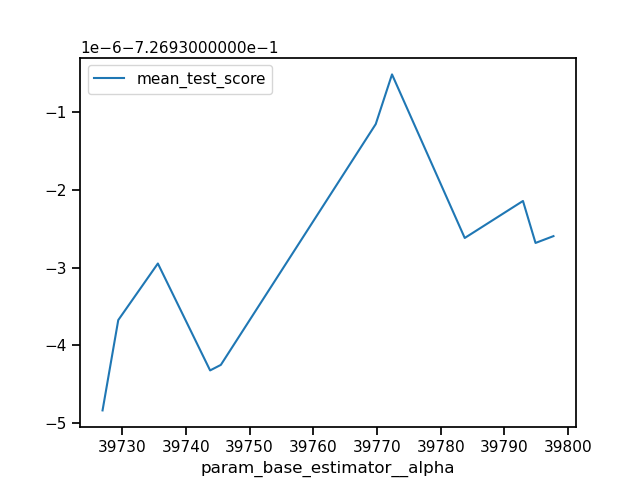

Fitting 8 folds for each of 11 candidates, totalling 88 fits
best score: -0.7269305172926561
best params: {'base_estimator__alpha': 39772.38457034082}


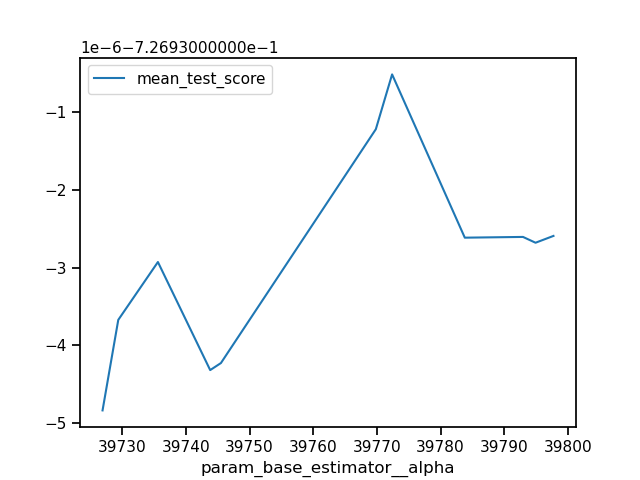

time: 45.1 s


In [52]:
df = tune(alpha=loguniform(39725, 39825), results_df=df, n_iter=11)
df = tune(alpha=uniform(39725, 100), results_df=df, n_iter=11)

Fitting 8 folds for each of 11 candidates, totalling 88 fits
best score: -0.7269294026050681
best params: {'base_estimator__alpha': 39759.475659969256}


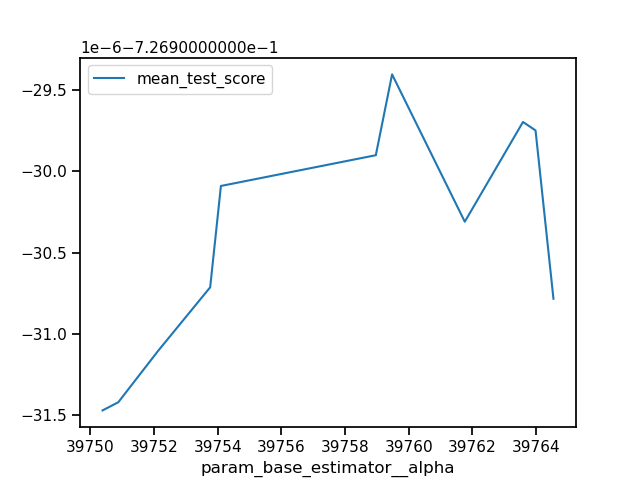

Fitting 8 folds for each of 11 candidates, totalling 88 fits
best score: -0.7269294025891323
best params: {'base_estimator__alpha': 39759.47691406817}


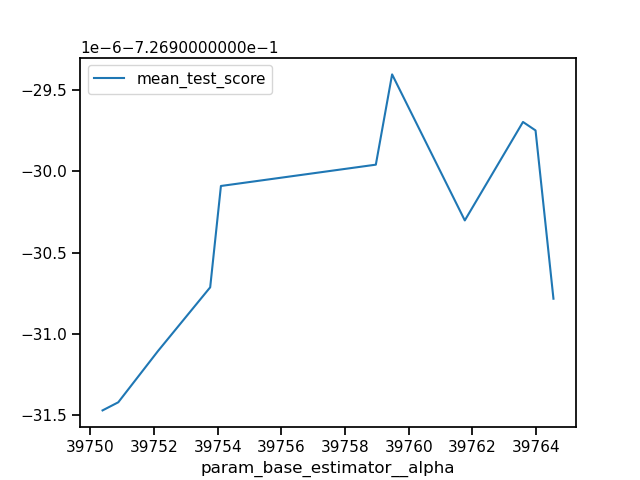

time: 45 s


In [60]:
df = tune(alpha=loguniform(39750, 39770), results_df=df, n_iter=11)
df = tune(alpha=uniform(39750, 20), results_df=df, n_iter=11)

In [61]:
_ = gc_collect()

time: 275 ms


In [62]:
results_df = df
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{DATA_OUT_FOLDER}/ridge_results.csv")

time: 9 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

param_base_estimator__alpha  mean_test_score
8                 39759.476914        -0.726929
8                  39759.47566        -0.726929
7                  39763.58801        -0.726930
7                 39763.586915        -0.726930
1                 39763.982175        -0.726930
1                 39763.981117        -0.726930
9                 39758.964672        -0.726930
9                 39758.965916        -0.726930
4                 39754.099559        -0.726930
4                 39754.100379        -0.726930
0                  39761.76029        -0.726930
0                 39761.759072        -0.726930
2                 39753.762271        -0.726931
2                 39753.763039        -0.726931
6                 39764.544803        -0.726931
6                 39764.543805        -0.726931
5                 39752.120781        -0.726931
5                 39752.121257        -0.726931
3                 39750.875961        -0.726931
3                 39750.876171        -0.726931
10                39750.382045        -0.726931
10                39750.382139        -0.726931
3                 76697.311104        -0.727554
48                75483.331345        -0.727569
20                75735.799888        -0.727570
10                75735.607937        -0.727570
41                78218.184544        -0.727570
3                 77190.428187        -0.727571
41                77506.882284        -0.727577
10                75955.347394        -0.727578
30                79205.397033        -0.727578
5                 79175.566509        -0.727579
21                78751.198283        -0.727582
24                78739.918166        -0.727586
35                79646.894003        -0.727586
5                 80303.143724        -0.727587
21                79777.107693        -0.727597
4                 83280.718166        -0.727604
45                83089.859783        -0.727608
2                 82566.246243        -0.727614
17                84150.325988        -0.727767
2                 84407.598002        -0.727768
39                84168.150119        -0.727769
32                84738.387082        -0.727780
45                85026.372194        -0.727781
23                85293.418535        -0.727792
4                  85250.94762        -0.727792
4                 91003.790479        -0.727798
48                85474.585227        -0.727801
28                91193.623574        -0.727802
20                85565.220352        -0.727802
29                91144.412413        -0.727803
30                89291.369424        -0.727810
32                86949.341622        -0.727810
35                86943.660854        -0.727810
24                89108.255972        -0.727811
30                86790.404433        -0.727811
48                87796.046569        -0.727812
0                 87110.918801        -0.727813
20                87899.781904        -0.727814
35                89464.057017        -0.727814
45                90105.488777        -0.727815
24                86628.190386        -0.727815
17                 86267.70816        -0.727816
39                 86288.43838        -0.727817
2                 87630.392008        -0.727818
23                87588.364338        -0.727820
40                92952.165131        -0.727830
38                92842.414985        -0.727831
28                 92570.19074        -0.727840
33                93792.751448        -0.727842
29                92412.893966        -0.727843
28                94135.381532        -0.727862
29                 94082.54751        -0.727867
16                94341.965717        -0.727871
9                 94300.746677        -0.727874
39                95153.753519        -0.727892
17                95070.832639        -0.727896
21                95542.153861        -0.727902
8                 95539.582738        -0.727902
38                97946.620667        -0.727907
40                96004.906947        -0.727912
38                9

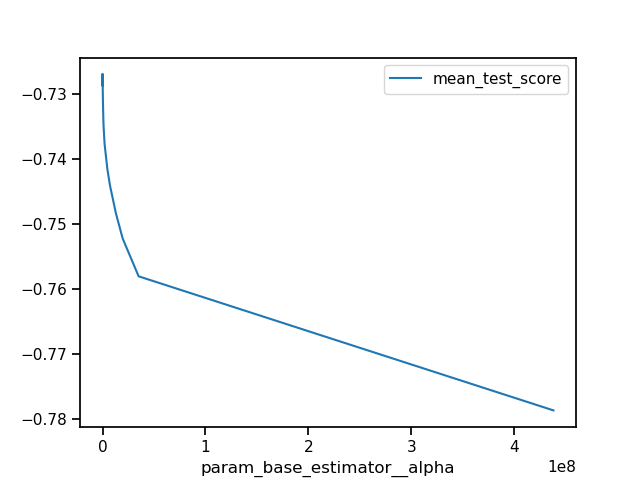

time: 224 ms


In [63]:
results_df = results_df.sort_values(by="param_base_estimator__alpha", ascending=True)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
df.sort_values(by="mean_test_score", ascending=False).head(100)

In [64]:
max_score = results_df.mean_test_score.max()
results_df.loc[results_df.mean_test_score == max_score]
results_df.loc[
    results_df.mean_test_score == max_score
].param_base_estimator__alpha.iloc[0]

param_base_estimator__alpha  mean_test_score
8                39759.476914        -0.726929

39759.47691406817

time: 13 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

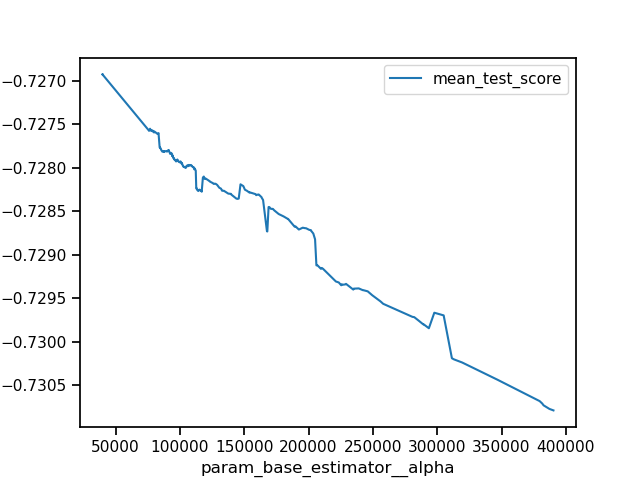

time: 240 ms


In [65]:
df = results_df.loc[results_df.param_base_estimator__alpha < 400000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

<AxesSubplot:xlabel='param_base_estimator__alpha'>

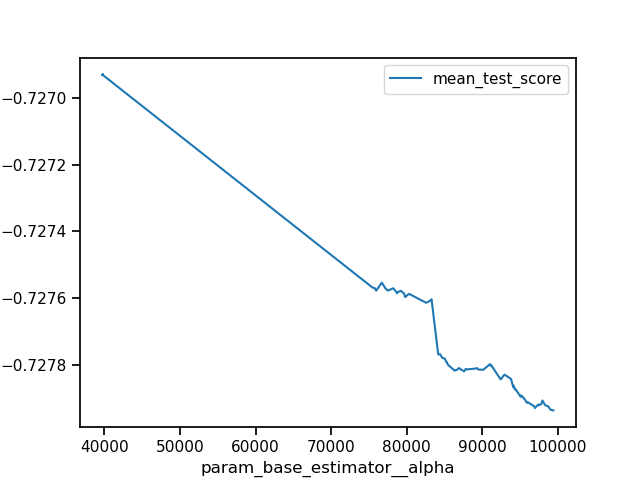

time: 134 ms


In [68]:
df = results_df.loc[results_df.param_base_estimator__alpha < 100000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

<AxesSubplot:xlabel='param_base_estimator__alpha'>

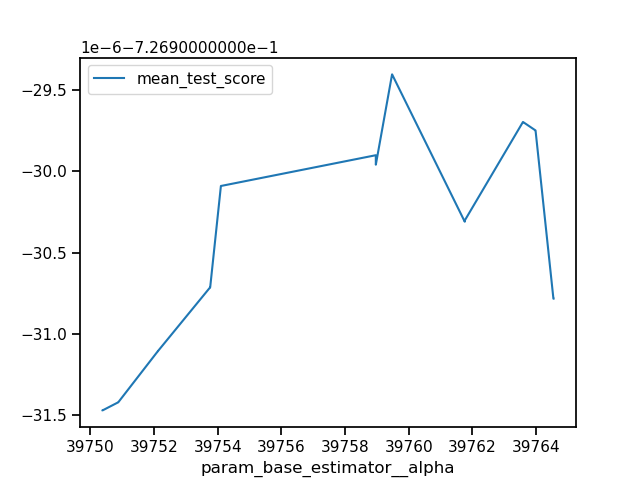

time: 148 ms


In [69]:
df = results_df.loc[results_df.param_base_estimator__alpha < 45000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

# Discussion

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [70]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 3527.134206533432 s
time: 223 ms


[^top](#Contents)